The goal of this notebook is to find optimal combinations of parameters for minimum model error. 

In [1]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions_controlled_conditions import *

import datetime

pandas version is 1.0.1


In [2]:
# Functions for optimization (i.e producing random parametric combination)
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression

In [3]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Parameters.xlsx')
x2 = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import indoor data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


Sample  Exp  Sleeve  Week Stage           Timei           Timeh  \
0     0.0    1       0   0.0     i  2019,3,12,13,0  2019,3,12,13,0   
1     0.7    1       0   0.0     f  2019,3,12,13,0  2019,3,12,13,0   
2     1.0    1       1   1.0     i  2019,3,19,13,0  2019,3,19,13,0   
3     2.0    1       2   1.0     i  2019,3,19,13,0  2019,3,19,13,0   
4     3.0    1       3   1.0     i  2019,3,19,13,0  2019,3,19,13,0   

             Time     DW   mmi  ...  Frequency  Amplitude  Duration    Flux  \
0  2019,3,12,13,0  0.750   NaN  ...        NaN        NaN       NaN     NaN   
1  2019,3,19,13,0  0.753  50.0  ...        NaN        NaN       NaN     NaN   
2  2019,3,19,13,0  0.144   NaN  ...        1.0     1000.0     168.0  1000.0   
3  2019,3,19,13,0  0.153   NaN  ...        1.0     1000.0     168.0  1000.0   
4  2019,3,19,13,0  0.159   NaN  ...        1.0     1000.0     168.0  1000.0   

   Sporulated  Comment  Day  Comment2  Unnamed: 38  N_Saturation  
0          No      NaN  NaN       NaN          NaN           yes  
1          No      NaN  NaN       NaN          NaN           yes  
2          No      NaN  NaN       NaN          NaN           yes  
3          No      NaN  NaN       NaN          NaN           yes  
4          No      NaN  NaN       NaN          NaN           yes  

[5 rows x 40 columns]

In [5]:
# b. process data (indoor measurements)

    # 1. Convert Time into hours
T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

    # 2. Make a temp DF (df2_temp) by filtering the original df - remove 'wierd' results (i.e sporulation) 

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')&(df2.Comment != 'Exclude')]
df2_Reduced

Sample  Exp  Sleeve  Week Stage            Timei            Timeh  \
11      1.7    1       1   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
12      2.7    1       2   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
13      3.7    1       3   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
14      4.7    1       4   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
15      5.7    1       5   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
..      ...  ...     ...   ...   ...              ...              ...   
467   144.7    5       4   3.0     f  2019,11,28,12,0  2019,12,12,12,0   
468   145.7    5       5   3.0     f  2019,11,28,12,0  2019,12,12,12,0   
469   146.7    5       6   3.0     f  2019,11,28,12,0  2019,12,12,12,0   
470   147.7    5       7   3.0     f  2019,11,28,12,0  2019,12,12,12,0   
471   148.7    5       8   3.0     f  2019,11,28,12,0  2019,12,12,12,0   

               Time     DW  mmi  ...  Amplitude  Duration    Flux  Sporulated  \
11   2019,3,26,10,0  0.408  4.8  ...     1000.0     168.0  1000.0          No   
12   2019,3,26,10,0  0.426  5.1  ...     1000.0     168.0  1000.0          No   
13   2019,3,26,10,0  0.330  5.3  ...     1000.0     168.0  1000.0          No   
14   2019,3,26,10,0  0.267  5.2  ...     2000.0       4.0  2000.0          No   
15   2019,3,26,10,0  0.267  4.8  ...     2000.0       4.0  2000.0          No   
..              ...    ...  ...  ...        ...       ...     ...         ...   
467  2019,12,19,9,0  0.426  5.0  ...      500.0     168.0  1000.0          No   
468  2019,12,19,9,0  0.321  5.0  ...      500.0     168.0  1500.0          No   
469  2019,12,19,9,0  0.297  5.0  ...      500.0     168.0  1500.0          No   
470  2019,12,19,9,0  0.357  5.0  ...      200.0     168.0  1000.0          No   
471  2019,12,19,9,0  0.336  5.0  ...      200.0     168.0  1000.0          No   

     Comment  Day  Comment2  Unnamed: 38  N_Saturation    T  
11       NaN  NaN       NaN          NaN           yes  165  
12       NaN  NaN       NaN          NaN           yes  165  
13       NaN  NaN       NaN          NaN           yes  165  
14       NaN  NaN       NaN          NaN            no  165  
15       NaN  NaN       NaN          NaN            no  165  
..       ...  ...       ...          ...           ...  ...  
467      NaN  NaN       NaN          NaN           yes  501  
468      NaN  NaN       NaN          NaN           yes  501  
469      NaN  NaN       NaN          NaN           yes  501  
470      NaN  NaN       NaN          NaN           yes  501  
471      NaN  NaN       NaN          NaN           yes  501  

[229 rows x 41 columns]

In [6]:
# 4. Calculate model results for:
#   a. Indoor system
    # I. Produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment

In [7]:
df2_Reduced

Sample  Exp  Sleeve  Week Stage            Timei            Timeh  \
11      1.7    1       1   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
12      2.7    1       2   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
13      3.7    1       3   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
14      4.7    1       4   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
15      5.7    1       5   1.0     f   2019,3,19,13,0   2019,3,19,13,0   
..      ...  ...     ...   ...   ...              ...              ...   
467   144.7    5       4   3.0     f  2019,11,28,12,0  2019,12,12,12,0   
468   145.7    5       5   3.0     f  2019,11,28,12,0  2019,12,12,12,0   
469   146.7    5       6   3.0     f  2019,11,28,12,0  2019,12,12,12,0   
470   147.7    5       7   3.0     f  2019,11,28,12,0  2019,12,12,12,0   
471   148.7    5       8   3.0     f  2019,11,28,12,0  2019,12,12,12,0   

               Time     DW  mmi  ...  Amplitude  Duration    Flux  Sporulated  \
11   2019,3,26,10,0  0.408  4.8  ...     1000.0     168.0  1000.0          No   
12   2019,3,26,10,0  0.426  5.1  ...     1000.0     168.0  1000.0          No   
13   2019,3,26,10,0  0.330  5.3  ...     1000.0     168.0  1000.0          No   
14   2019,3,26,10,0  0.267  5.2  ...     2000.0       4.0  2000.0          No   
15   2019,3,26,10,0  0.267  4.8  ...     2000.0       4.0  2000.0          No   
..              ...    ...  ...  ...        ...       ...     ...         ...   
467  2019,12,19,9,0  0.426  5.0  ...      500.0     168.0  1000.0          No   
468  2019,12,19,9,0  0.321  5.0  ...      500.0     168.0  1500.0          No   
469  2019,12,19,9,0  0.297  5.0  ...      500.0     168.0  1500.0          No   
470  2019,12,19,9,0  0.357  5.0  ...      200.0     168.0  1000.0          No   
471  2019,12,19,9,0  0.336  5.0  ...      200.0     168.0  1000.0          No   

     Comment  Day  Comment2  Unnamed: 38  N_Saturation    T  
11       NaN  NaN       NaN          NaN           yes  165  
12       NaN  NaN       NaN          NaN           yes  165  
13       NaN  NaN       NaN          NaN           yes  165  
14       NaN  NaN       NaN          NaN            no  165  
15       NaN  NaN       NaN          NaN            no  165  
..       ...  ...       ...          ...           ...  ...  
467      NaN  NaN       NaN          NaN           yes  501  
468      NaN  NaN       NaN          NaN           yes  501  
469      NaN  NaN       NaN          NaN           yes  501  
470      NaN  NaN       NaN          NaN           yes  501  
471      NaN  NaN       NaN          NaN           yes  501  

[229 rows x 41 columns]

In [8]:
# optimized parameters: bounds
#'µmax'
problem = {
    'num_vars': 9,
    'names': ['λ20','Nintmax','Nintcrit','Nextlosses','Ks','Vmax','KI','K0','Ka'],
    'bounds': [[0.001,0.005],
               [4.5,5],
               [0.7,3.2],
               [0.001,0.02],
               [10,30],
               [50,250],
               [15, 150],
               [0.1,3],
               [0.01,0.2]]
}

print(problem)

{'num_vars': 9, 'names': ['λ20', 'Nintmax', 'Nintcrit', 'Nextlosses', 'Ks', 'Vmax', 'KI', 'K0', 'Ka'], 'bounds': [[0.001, 0.005], [4.5, 5], [0.7, 3.2], [0.001, 0.02], [10, 30], [50, 250], [15, 150], [0.1, 3], [0.01, 0.2]]}


In [9]:
# number of examined values per parameter - 100
param_values = saltelli.sample(problem, 250)
print(param_values.shape)

(5000, 9)


In [10]:
# model simulations with different parameteric combinations


Y1 = np.zeros([param_values.shape[0]])
Y2 = np.zeros([param_values.shape[0]])

evaluate_model1 = []
evaluate_model2 = []

Temp = 22
S = 39 # fix salinity function and S=40

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

r = 0

miu = 0.03
for p, X in enumerate(param_values):
   
    #miu = X[0]
    lossess20 = X[0]
    Nintmax = X[1]
    Nintcrit = X[2]
    dNextoutdt = X[3]
    Ks = X[4]
    Vmax = X[5]
    KI = X[6]
    K0 = X[7]
    Ka = X[8]


    
    TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
    mExpAllTimes,NintExpAllTimes,NextExpAllTimes = [],[],[]
    mModAll,NintModAll,NextModAll = [],[],[]

    for i in Treatments:
        df2_ReducedTemp = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
        df2Temp = df2_ReducedTemp[(df2_ReducedTemp.Treatment == i)]
        #mTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['DW']
        #mTimeTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['T']
        #NintTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['N']
        #NintTimeTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['T']
        #NextTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['NH4']
        #NextTimeTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['T']
        mTemp = df2Temp[(~np.isnan(df2Temp.DW))]['DW']
        mTimeTemp = df2Temp[(~np.isnan(df2Temp.DW))]['T']
        NintTemp = df2Temp[(~np.isnan(df2Temp.N))]['N']
        NintTimeTemp = df2Temp[(~np.isnan(df2Temp.N))]['T']
        NextTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['NH4']
        NextTimeTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['T']

        Tr = []
        Tr = i.split('/')
        Tr = [float(i) for i in Tr]
        Amplitude = Tr[0]
        Period = float(7/Tr[1]) # Period is in hours
        Duration = Tr[2]/24

        NEXT, NINT, M, TT = [],[],[],[]

        n_days = Duration*3
        count_periods = 0

        # hour = 0 is 1pm
        # in the indoor settings we have to solve for shorter periods, 
        # at the beginning of the Treatment we reset Nint, Next, m
        # at the beginning of each Period we set Next to the last Amplitude, 
        # m0 to the end of previous solution of ode()

        # Let's prepare the IO(t) function that will be supplied to odeint 
        # instead of a scalar. 

        all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)

        # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
        offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
        offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever

        # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
        ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
        # and the iniital hour as we always start at 1pm, during ontime
        ontimes = np.r_[np.int(0),ontimes]

        # prepare the duty cycle
        I0set = np.zeros_like(all_treatment_hours)
        for s,e in zip(ontimes,offtimes):
            I0set[s:e] = 80

        # if you want to replace it by a "constant" I0 then replace the lines above with
        # the following line and then it will also give you a constant solution you had before

        # I0set = np.ones_like(all_treatment_hours)*80


        I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")

        for hour in np.arange(0,n_days*24,round(Period*24,0)):
            if hour == 0:
                Nint_0 = Nint0All[Treatments.index(i)]
                m_0 = m0
                Next_0 = Amplitude

            if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
                count_periods = count_periods + 1

                if count_periods == Tr[1]:
                    # reset everything, except Nint
                    Nint_0 = NINT[-1][-1]
                    Next_0 = Amplitude
                    m_0 = m0
                    count_periods = 0
                else:
                    # period passed, not Duration
                    # add amplitude, keep going 
                    Next_0 = NEXT[-1][-1] + Amplitude
                    Nint_0 = NINT[-1][-1]
                    m_0 = M[-1][-1]


            # Here we want to send odeint the times of the light sub-period or 
            # darkness sub-period

            x0 = [Next_0,Nint_0,m_0]
            # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
            t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

            x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                                                   losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

            NEXT.append(x[: , 0])
            NINT.append(x[: , 1])
            M.append(x[: , 2])
            TT.append(t)

            t_model = np.hstack(TT)
            Next_model = np.hstack(NEXT)
            Nint_model = np.hstack(NINT)
            m_model = np.hstack(M)

        TModAll.append(TT)
        mExpAllTimes.append(mTimeTemp)
        NintExpAllTimes.append(NintTimeTemp)
        NextExpAllTimes.append(NextTimeTemp)

        mModAll.append(m_model)
        NintModAll.append(Nint_model)
        NextModAll.append(Next_model)
        
    # Adjusts measurment time to model durations - so that maximum biomass measurements are compared to maximum biomass
    # predictions and not to the initial stocking density (m0)

    TModTemp = []
    TModAllOrg = []
    mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
    for j in range(len(TModAll)): # loops over 5 treatments
        #print(j)
        for k in range(len(TModAll[j])): # Loops over periods in each treatment
            Ttemp = TModAll[j][k]
            for l in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
                if l > 504:
                    l = 504
                TModTemp.append(l)
        TModAllOrg.append(TModTemp)
        TModTemp = []

    for j in range(len(TModAll)):
        gm = interpolate.interp1d(TModAllOrg[j], mModAll[j],kind = 'linear')
        mModReduced = []
        for k in mExpAllTimes[j]:
            #print(mExpAllTimes[i])
            if k >= 168 and k < 180:
                k = 167.9
            elif k >= 336 and k < 345:
                k = 335.9
            elif k > 504:
                k = 504
            #print(j)
            mModReduced.append(gm(k-1))

        mModReducedAll.append(mModReduced)
        gNint = interpolate.interp1d(TModAllOrg[j], NintModAll[j],kind = 'linear')
        NintModReduced = []
        for k in NintExpAllTimes[j]:
            if k >= 168 and k < 180:
                k = 167.9
            if k >= 336 and k < 345:
                k = 335.9
            if k > 504:
                k = 504
            NintModReduced.append(gNint(k-1))
        NintModReducedAll.append(NintModReduced)
        gNext = interpolate.interp1d(TModAllOrg[j], NextModAll[j],kind = 'linear')    
        NextModReduced = []
        for k in NextExpAllTimes[j]:
            if k >= 168 and k < 180:
                k = 167.9
            if k >= 336 and k < 345:
                k = 335.9
            if k > 504:
                k = 504
            NextModReduced.append(gNext(k-1))
        NextModReducedAll.append(NextModReduced)

    
    # calculate errors
    mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
    for j in range(len(Treatments)):
        mSRE,NintSRE,NextSRE = [],[],[]
        RMSREmAll,RMSRENintAll = [],[]
        
        df2m = df2_ReducedTemp[(np.isnan(df2_ReducedTemp.DW) != True)&(df2_ReducedTemp.Treatment == Treatments[j])]
        #print('Treatment: ' + str(Treatments[j]) + '\n\nm\n')
        #print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
        l = 0
        for k in df2m.Sample:
            mexp = df2m.DW
            #print(j)
            #print(len(mModReducedAll))
            mmod = mModReducedAll[j]
            mSRE.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
            mSRE_All.append(((mexp.iloc[l]-mmod[l])/mmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured biomass: ' + str(round(mexp.iloc[l],3)))
            #print('Modeled biomass: ' + str(round(float(mmod[l]),3)) + '\n')
            l = l + 1
            RMSREm = round((np.mean(mSRE))**0.5,3)
            
        #print('The RMSRE of m in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSREm) + '\n')


        df2Nint = df2_ReducedTemp[(np.isnan(df2_ReducedTemp.N) != True)][(df2_ReducedTemp.Treatment == Treatments[j])]
        #print('\nNint\n')
        #print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
        l = 0
        for k in df2Nint.Sample:
            Nintexp = df2Nint.N
            Nintmod = NintModReducedAll[j]
            NintSRE.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)
            NintSRE_All.append(((Nintexp.iloc[l]-Nintmod[l])/Nintmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured Nint: ' + str(round(float(Nintexp.iloc[l]),3)))     
            #print('Modeled Nint: ' + str(round(float(Nintmod[l]),3)) + '\n')        
            l = l + 1
            RMSRENint = round((np.mean(NintSRE))**0.5,3)
            
        #print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSRENint) + '\n')

        df2Next = df2_ReducedTemp[(np.isnan(df2_ReducedTemp.NH4) != True)][(df2_ReducedTemp.Treatment == Treatments[j])]
        #print('\nNext\n')
        #print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
        l = 0
        for k in df2Next.Sample:
            Nextexp = df2Next.NH4
            if Nextexp.iloc[l] < 0:
                Nextexp.iloc[l] = 0
            Nextmod = NextModReducedAll[j]
            NextSRE.append(((Nextexp.iloc[l]-Nextmod[l])/Nextmod[l])**2)
            #print('Sample #' + str(math.floor(float(k))))
            #print('Measured Next: ' + str(round(float(Nextexp.iloc[l]),3)))     
            #print('Modeled Next: ' + str(round(float(Nextmod[l]),3)) + '\n')        
            l = l + 1
            RMSRENext = round((np.mean(NextSRE))**0.5,3)
            NextSRE_All.append(NextSRE)
        #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[j]) + ' is: ' + str(RMSRENext) + '\n')
    #print('End of treatment ' + str(Treatments[j]) + '\n')
    

    #mSRE_AllTemp = []
    #for i in range(len(mSRE_All)):
    #    for j in range(len(mSRE_All[i])):
    #        mSRE_AllTemp.append(mSRE_All[i][j])
    RMSREm = round((np.mean(mSRE_All))**0.5,3)

    #NintSRE_AllTemp = []
    #for i in range(len(NintSRE_All)):
    #    for j in range(len(NintSRE_All[i])):
    #        NintSRE_AllTemp.append(NintSRE_All[i][j])
    RMSRENint = round((np.mean(NintSRE_All))**0.5,3)
    
    evaluate_model1.append(RMSREm)
    evaluate_model2.append(RMSRENint)
    #evaluate_model3.append(RMSRENext)

    Y1[p] = round(evaluate_model1[-1],3)
    Y2[p] = round(evaluate_model2[-1],3)
    print(r)
    r = r+1

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:233: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:250: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [11]:
mSRE_All

[0.010283151799101622,
 0.010158726108264219,
 3.467966331006234e-05,
 0.00241196884944198,
 0.016442825630317758,
 0.08830976577327695,
 0.002019945697162673,
 0.00011738977513121103,
 0.11213897453842142,
 0.014857462730557831,
 0.019304005622538388,
 0.1355417785761657,
 0.21423683003588,
 0.0600375404014283,
 0.10021752807605651,
 0.045241748171002405,
 0.12881873080640982,
 0.06985733293664409,
 0.08267780038250866,
 0.07762080195139433,
 0.14548153486840984,
 0.2652104516829622,
 0.1558925184251069,
 0.2994492086558917,
 0.07255584897495398,
 0.18595661629396534,
 0.30304560319876245,
 0.003021088506728557,
 0.0036502099725372558,
 0.0006822451959673364,
 0.024795536358507467,
 0.0042069194936660845,
 0.04230991226110411,
 0.02227681701447376,
 0.0037222794063523517,
 0.006883428587549461,
 0.01370669831607783,
 0.0007777629092927008,
 0.031246456505429867,
 0.004973757940512669,
 0.020351160475499758,
 0.020351160475499758,
 0.12662200723820408,
 0.016956190436323237,
 0.0079797

In [12]:
min(Y1),min(Y2)

(0.153, 0.199)

In [13]:
print(min(Y1))
print(np.mean(Y1))
print(np.std(Y1))
print(np.median(Y1))
print(max(Y1))

0.153
0.6192434
0.2678634363933234
0.649
1.122


In [14]:
Si1 = sobol.analyze(problem, Y1,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
λ20 0.000000 0.000000 0.000000 0.000000
Nintmax 0.000000 0.000000 0.000000 0.000000
Nintcrit 0.000000 0.000000 0.000000 0.000000
Nextlosses 0.000000 0.000000 0.000000 0.000000
Ks 0.000000 0.000000 0.000000 0.000000
Vmax 0.000000 0.000000 0.000000 0.000000
KI 0.685887 0.122854 0.713646 0.114508
K0 0.005280 0.012497 0.004607 0.001263
Ka 0.306798 0.096578 0.358238 0.069451

Parameter_1 Parameter_2 S2 S2_conf
λ20 Nintmax 0.000000 0.000000
λ20 Nintcrit 0.000000 0.000000
λ20 Nextlosses 0.000000 0.000000
λ20 Ks 0.000000 0.000000
λ20 Vmax 0.000000 0.000000
λ20 KI -0.000000 0.000000
λ20 K0 0.000000 0.000000
λ20 Ka 0.000000 0.000000
Nintmax Nintcrit -0.000026 0.000052
Nintmax Nextlosses -0.000026 0.000052
Nintmax Ks -0.000026 0.000052
Nintmax Vmax -0.000026 0.000052
Nintmax KI -0.000018 0.000037
Nintmax K0 -0.000026 0.000052
Nintmax Ka -0.000026 0.000052
Nintcrit Nextlosses 0.000000 0.000000
Nintcrit Ks 0.000000 0.000000
Nintcrit Vmax 0.000000 0.000000
Nintcrit KI

In [15]:
print(min(Y2))
print(np.mean(Y2))
print(np.std(Y2))
print(np.median(Y2))
print(max(Y2))

0.199
0.3836144
0.05077493980931932
0.398
0.459


In [16]:
Si2 = sobol.analyze(problem, Y2,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
λ20 0.000000 0.000000 0.000000 0.000000
Nintmax 0.053525 0.051613 0.072196 0.015311
Nintcrit 0.000000 0.000000 0.000000 0.000000
Nextlosses 0.024400 0.048121 0.085741 0.030115
Ks 0.001223 0.005473 0.000840 0.000218
Vmax 0.167909 0.066195 0.224130 0.052473
KI 0.429283 0.114215 0.494470 0.136164
K0 -0.000606 0.010732 0.004035 0.001767
Ka 0.195326 0.094274 0.285363 0.073434

Parameter_1 Parameter_2 S2 S2_conf
λ20 Nintmax 0.000000 0.000000
λ20 Nintcrit 0.000000 0.000000
λ20 Nextlosses 0.000000 0.000000
λ20 Ks 0.000000 0.000000
λ20 Vmax 0.000000 0.000000
λ20 KI 0.000000 0.000000
λ20 K0 -0.000000 0.000000
λ20 Ka 0.000000 0.000000
Nintmax Nintcrit 0.036683 0.066235
Nintmax Nextlosses 0.039674 0.065946
Nintmax Ks 0.036148 0.066142
Nintmax Vmax 0.031621 0.073473
Nintmax KI 0.032583 0.075959
Nintmax K0 0.039203 0.067763
Nintmax Ka -0.006776 0.072721
Nintcrit Nextlosses 0.000000 0.000000
Nintcrit Ks 0.000000 0.000000
Nintcrit Vmax 0.000000 0.000000
Nintcrit KI 0.00

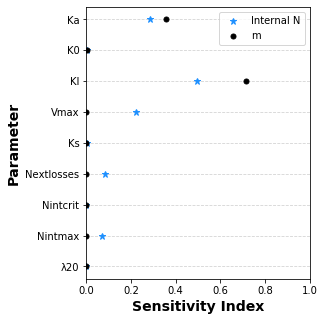

In [17]:
fig,ST2 = plt.subplots(1,1,sharex=True,figsize=(4,5))
#ST2.plot(Si3['ST'],problem['names'],'s',markersize=5,color='dimgray')
ST2.plot(Si2['ST'],problem['names'],'*',markersize=7,color='dodgerblue')
ST2.plot(Si1['ST'],problem['names'],'.',markersize=10,color='black')


ST2.set_xlabel('Sensitivity Index',fontsize=14, weight="bold")
ST2.set_ylabel('Parameter',fontsize=14, weight="bold")
ST2.set_xlim([0, 1])
ST2.set_axisbelow(True)
ST2.yaxis.grid(color='lightgray', linestyle='dashed')
ST2.legend(['Internal N','m'])


name = 'Indoor Sensitivity.png' 
fig.savefig(fname=name, dpi=600)

In [18]:
a = param_values.T

a

array([[1.87890625e-03, 1.27734375e-03, 1.87890625e-03, ...,
        4.63867188e-03, 4.63867188e-03, 4.63867188e-03],
       [4.54833984e+00, 4.54833984e+00, 4.54248047e+00, ...,
        4.73706055e+00, 4.73706055e+00, 4.73706055e+00],
       [1.99638672e+00, 1.99638672e+00, 1.99638672e+00, ...,
        9.42919922e-01, 9.42919922e-01, 9.42919922e-01],
       ...,
       [2.11962891e+01, 2.11962891e+01, 2.11962891e+01, ...,
        1.83618164e+01, 1.83618164e+01, 1.83618164e+01],
       [2.70830078e+00, 2.70830078e+00, 2.70830078e+00, ...,
        2.13198242e+00, 1.66552734e-01, 1.66552734e-01],
       [1.05185547e-01, 1.05185547e-01, 1.05185547e-01, ...,
        1.46284180e-01, 8.96923828e-02, 1.46284180e-01]])

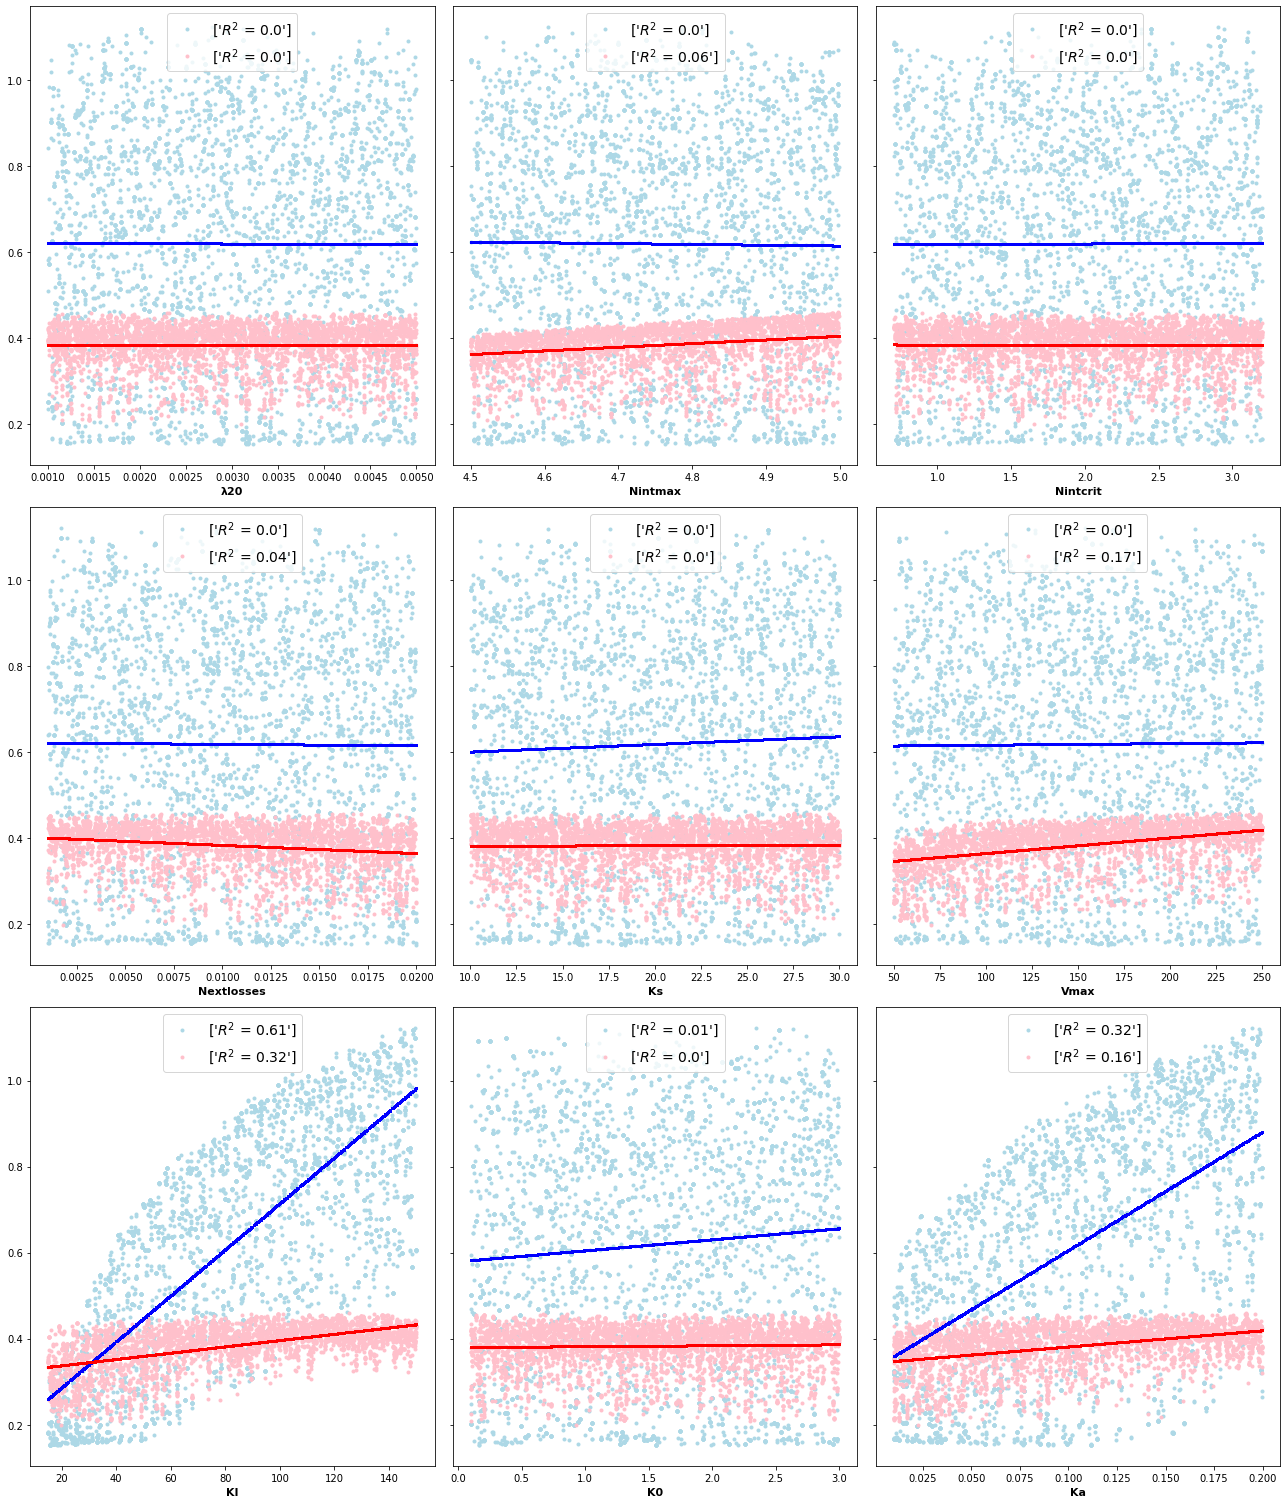

In [19]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 5) & (Y2[i] < 5):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(3,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Indoor Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

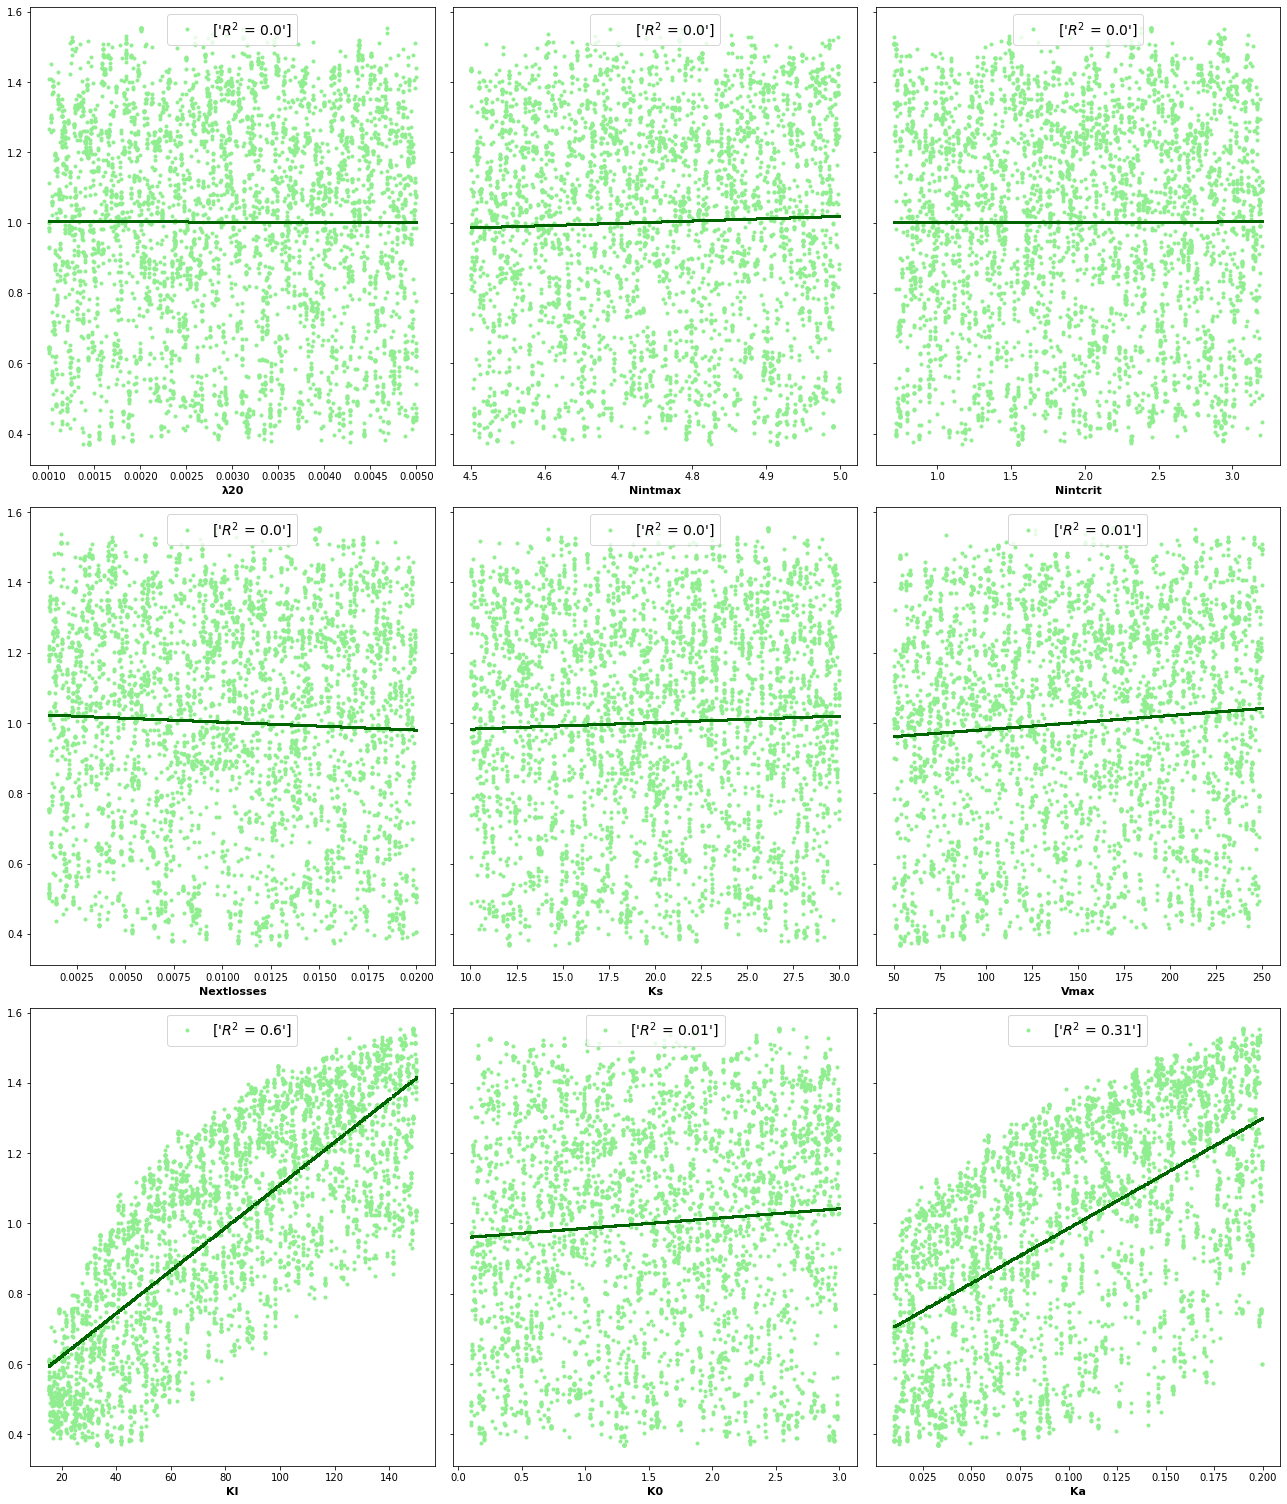

In [20]:
Y3 = Y1+Y2
Best_index = []
for i in range(len(Y3)):
    Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(3,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sq = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Indoor Combined Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

In [21]:
dfP = pd.DataFrame(param_values[0:-1])
dfY1 = pd.DataFrame(Y1[0:-1])
dfY2 = pd.DataFrame(Y2[0:-1])
dfP.to_csv('Indoor_param_values.csv',index=False)
dfY1.to_csv('Indoor_Y1.csv',index=False)
dfY2.to_csv('Indoor_Y2.csv',index=False)

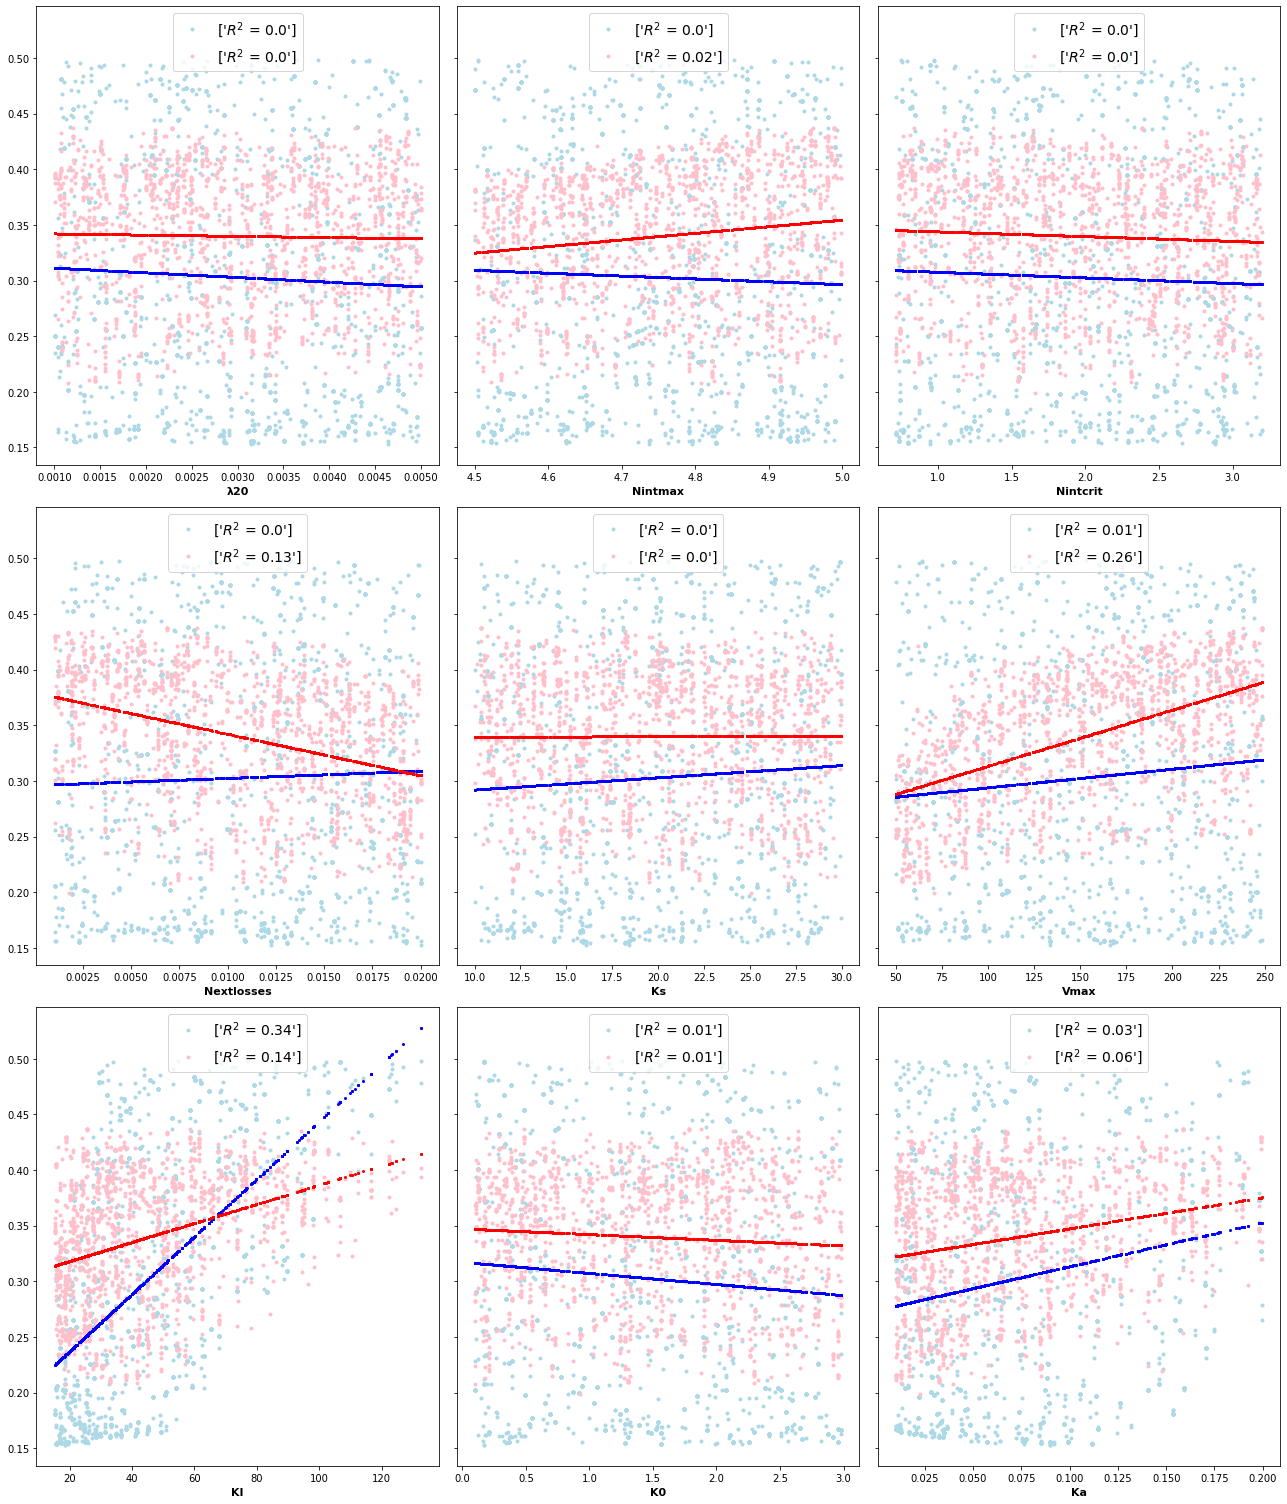

In [22]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 0.5) & (Y2[i] < 0.5):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        #.twinx()
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(3,3,figsize=(18,21),sharey=True)#,sharex=True)

#ax2 = ax0[0].twinx()

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

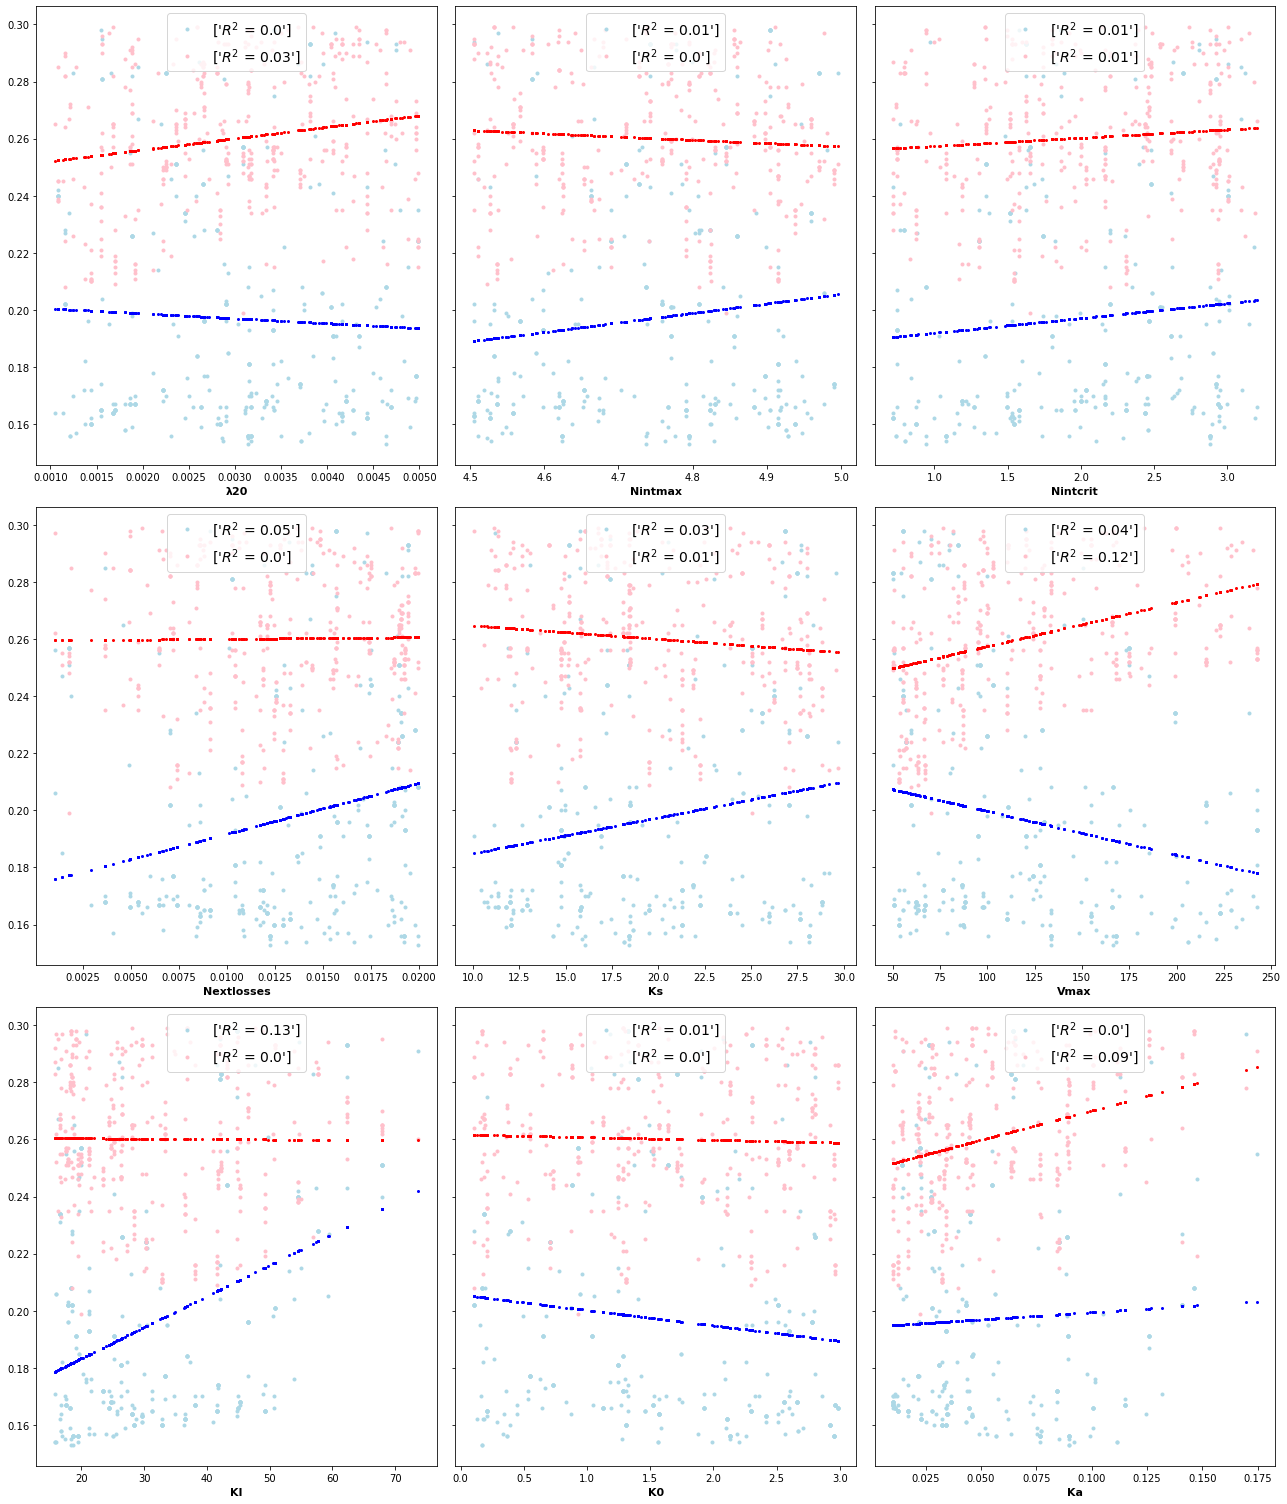

In [23]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 0.3) & (Y2[i] < 0.3):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(3,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

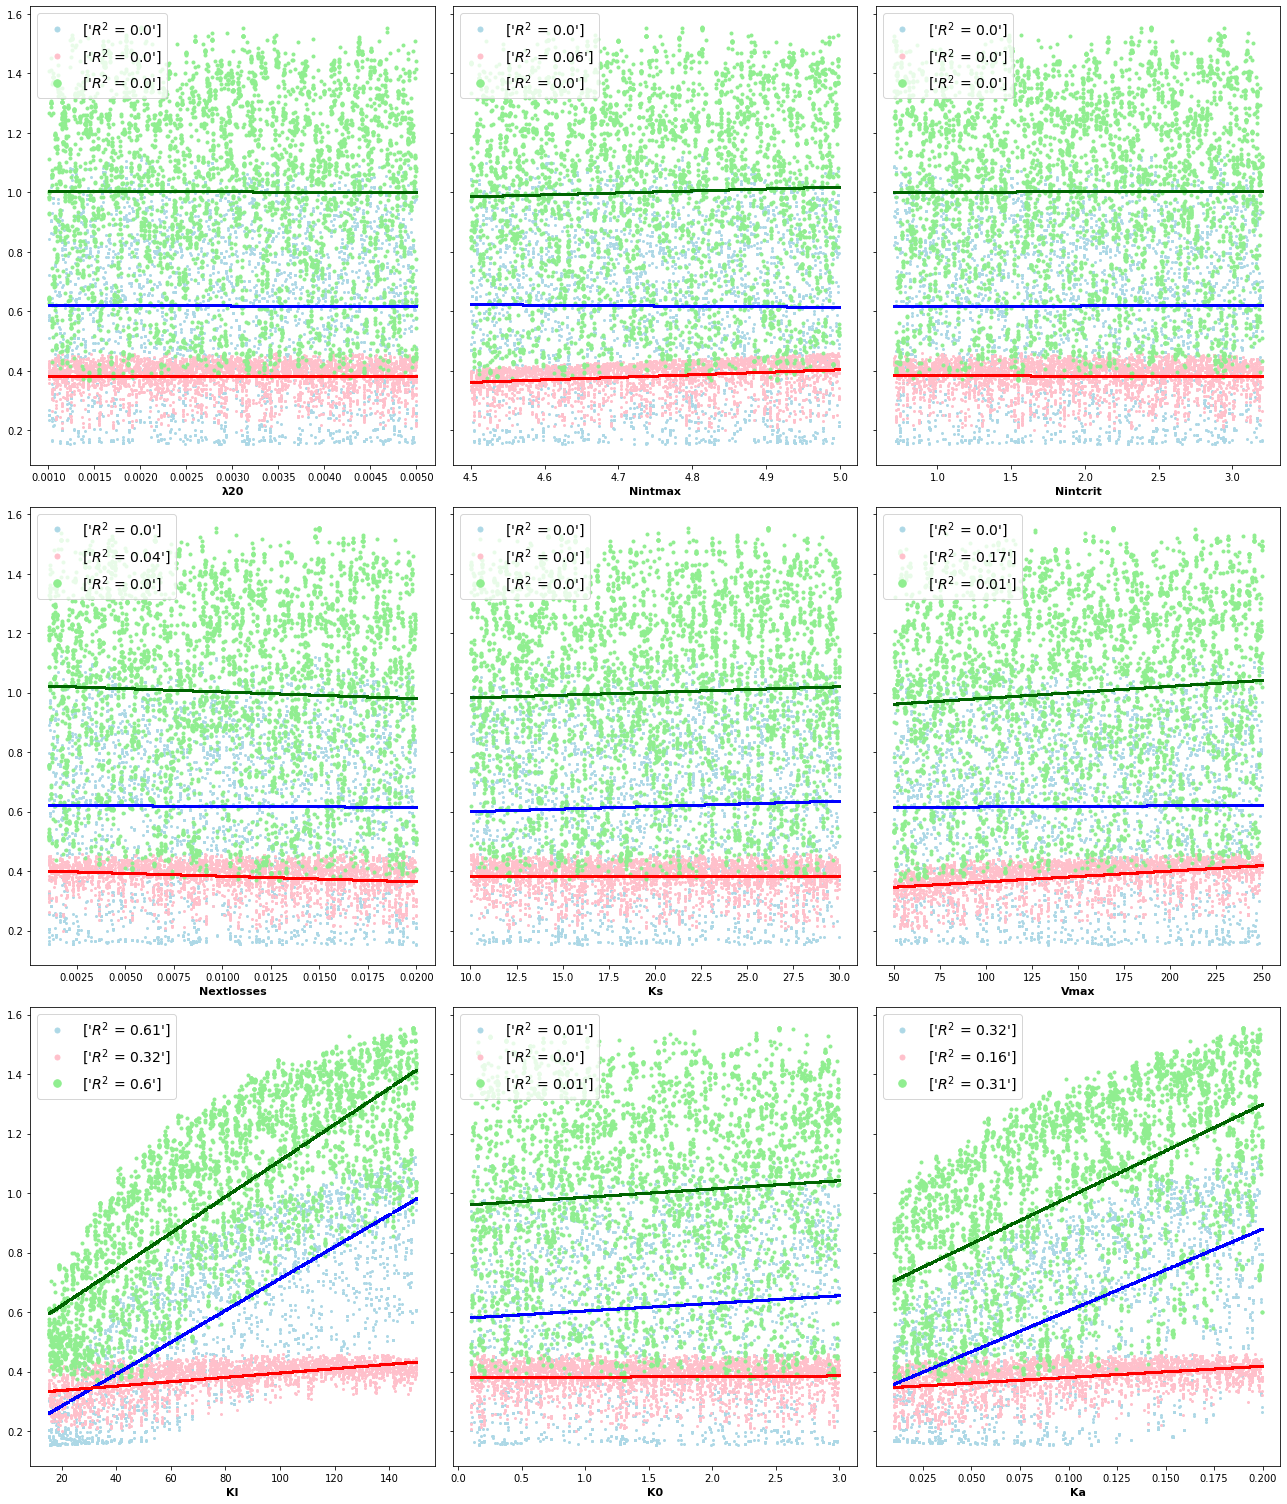

In [24]:
Y3 = Y1 + Y2
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 5) & (Y2[i] < 5):
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(3,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    
    # Combined (Y3)
    
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    #ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sqC = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')
    
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))],['$R^{2}$ = ' + str(round(r_sqC,2))]],fontsize = 14,loc = 'upper left',markerscale = 2.5)

    
plt.tight_layout()
plt.show()

name = 'Indoor Full Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

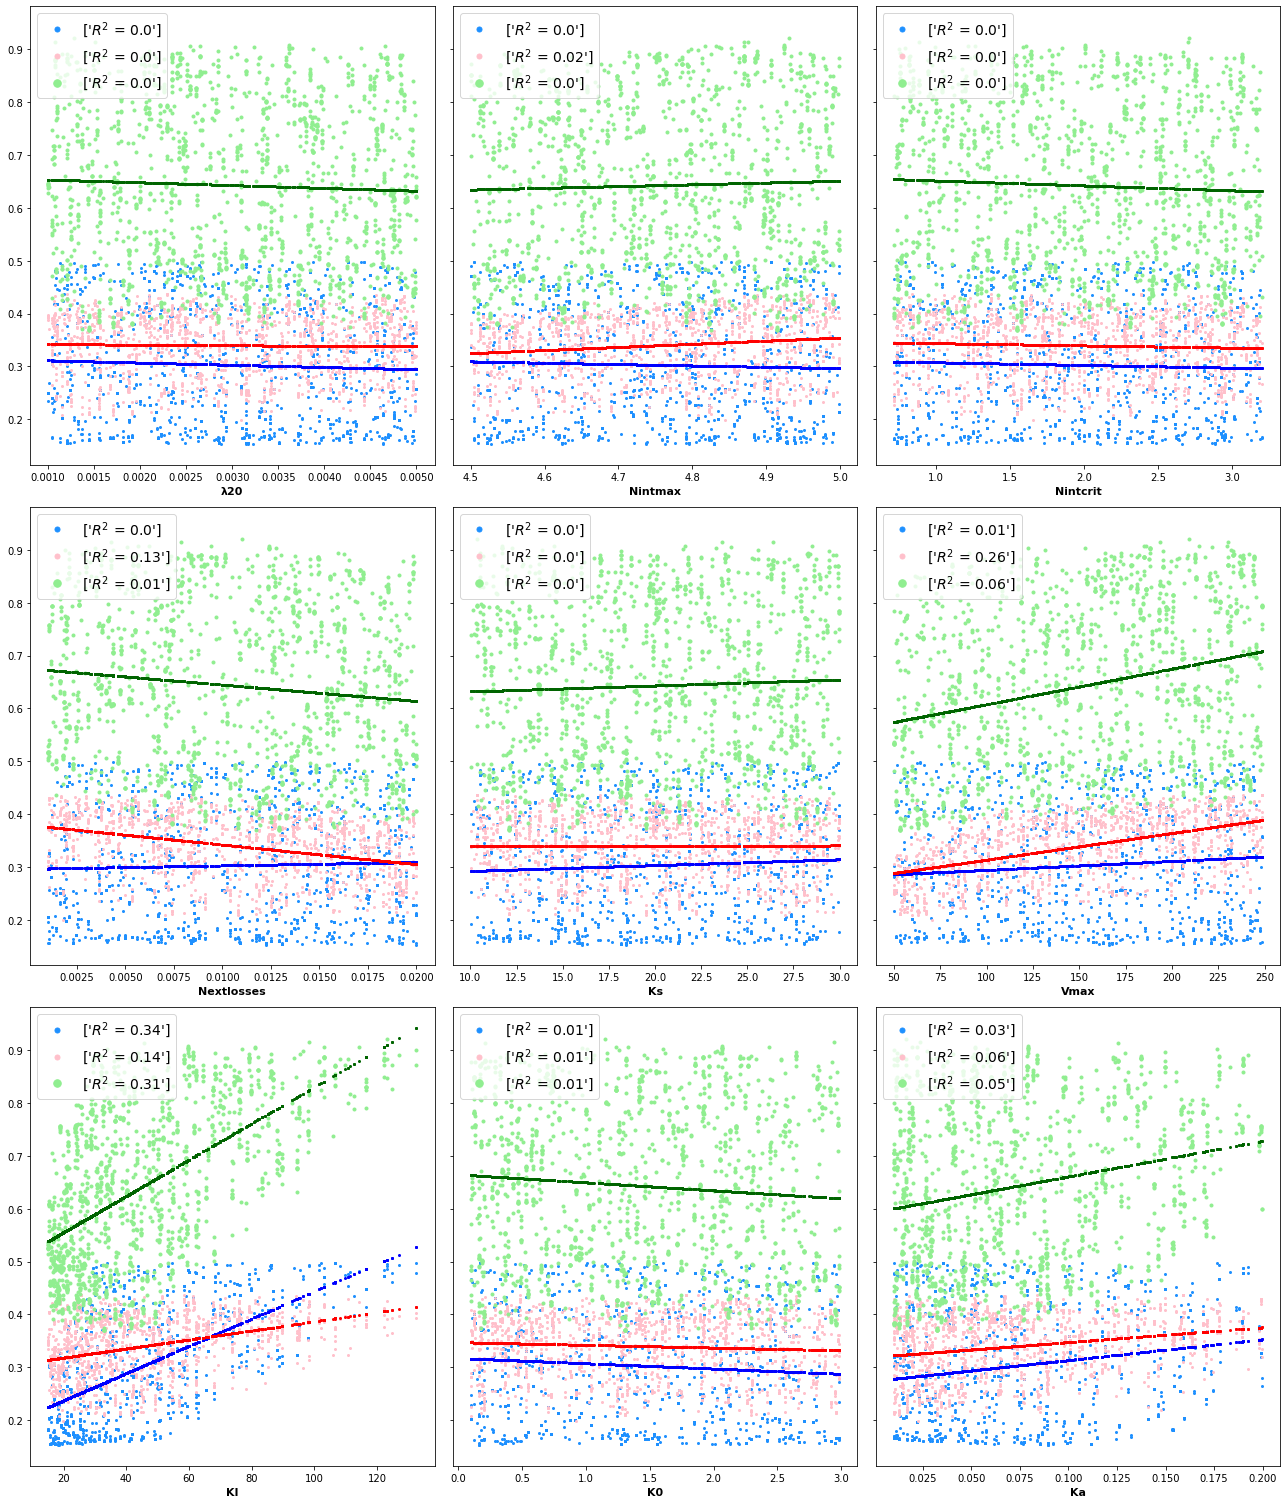

In [25]:
Y3 = Y1 + Y2
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 0.5) & (Y2[i] < 0.5):
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(3,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'dodgerblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    
    # Combined (Y3)
    
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    #ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sqC = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')
    
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))],['$R^{2}$ = ' + str(round(r_sqC,2))]],fontsize = 14,loc = 'upper left',markerscale = 2.5)

    
plt.tight_layout()
plt.show()

name = 'Indoor Error plots reduced.png' 
    
fig.savefig(fname=name, dpi=600)

In [26]:
Y3 = Y1 + Y2

In [27]:
# best parametric combinations

Y1.tolist().index(min(Y1)),Y2.tolist().index(min(Y2))
param_values[Y1.tolist().index(min(Y1))],param_values[Y2.tolist().index(min(Y2))]

(array([3.14648437e-03, 4.79565430e+00, 2.88383789e+00, 1.22534180e-02,
        1.84082031e+01, 1.33691406e+02, 1.86254883e+01, 1.66552734e-01,
        8.96923828e-02]),
 array([3.09179687e-03, 4.84448242e+00, 1.65581055e+00, 1.80712891e-03,
        2.50488281e+01, 7.04101562e+01, 1.99438477e+01, 9.25537109e-01,
        2.23388672e-02]))

In [28]:

minerrorm = min(Y1)
minerrorN = min(Y2)
minsumerrors = min(Y3)

merror_best = Y1[Y3.tolist().index(min(Y3))]
Nerror_best = Y2[Y3.tolist().index(min(Y3))]

#indminerrorm = Y1.tolist().index(min(Y3))
#indminerrorN = Y2.tolist().index(min(Y3))
BestParam_m = param_values[Y1.tolist().index(min(Y1))]
BestParam_N = param_values[Y2.tolist().index(min(Y2))]
BestParam = param_values[Y3.tolist().index(min(Y3))]

print('Minimum error for m: ' + str(minerrorm))
print('Minimum error for Nint: ' + str(minerrorN) + '\n')
print('Minimum sum of errors: ' + str(minsumerrors) + '\n')
print('Best error for m: ' + str(merror_best))
print('Best error for N: ' + str(Nerror_best))

for i in range(len(problem['names'])):
    print('Parameter: ' + str(problem['names'][i]) + ' Best values: ' + str(round(BestParam_m[i],3)) + ' , ' +str(round(BestParam_N[i],3)) + ' and: ' +str(round(BestParam[i],3))+'\n')

Minimum error for m: 0.153
Minimum error for Nint: 0.199

Minimum sum of errors: 0.37

Best error for m: 0.16
Best error for N: 0.21
Parameter: λ20 Best values: 0.003 , 0.003 and: 0.001

Parameter: Nintmax Best values: 4.796 , 4.844 and: 4.825

Parameter: Nintcrit Best values: 2.884 , 1.656 and: 1.546

Parameter: Nextlosses Best values: 0.012 , 0.002 and: 0.013

Parameter: Ks Best values: 18.408 , 25.049 and: 12.08

Parameter: Vmax Best values: 133.691 , 70.41 and: 53.223

Parameter: KI Best values: 18.625 , 19.944 and: 32.864

Parameter: K0 Best values: 0.167 , 0.926 and: 1.305

Parameter: Ka Best values: 0.09 , 0.022 and: 0.033



In [29]:
# II. Make a filtered array including only times of empiric measurement (remove from array results from times in which data was not measured)
# III. Add relevant columns from df2_temp and the model results to a new df_combined

In [30]:
Y3.tolist().index(min(Y3))

1422

In [31]:
X = param_values[Y3.tolist().index(min(Y3))].tolist()
X

# [0.00448046875, 4.2197265625, 2.81181640625, 0.0103330078125, 25.60546875, 54.4921875, 21.7236328125,
# 1.40556640625, 0.017607421875, 0.830078125, 23.14453125, 45.400390625, 19.794921875, 34.357421875, 5.2041015625]

[0.001443359375,
 4.824951171875,
 1.545947265625,
 0.01292138671875,
 12.080078125,
 53.22265625,
 32.86376953125,
 1.3050292968750001,
 0.0325439453125]

In [32]:
#miu = X[0]
miu = 0.03
lossess20 = X[0]
Nintmax = X[1]
Nintcrit = X[2]
dNextoutdt = X[3]
Ks = X[4]
Vmax = X[5]
KI = X[6]
K0 = X[7]
Ka = X[8]


Treatment: 1000/1/168
Number of samples:
m: 27 Nint: 19 Next: 26
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 500/2/168
Number of samples:
m: 66 Nint: 38 Next: 90
3.5
0.0
Starting point
84.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
252.0
Period
336.0
Duration
420.0
Period

Treatment: 500/3/168
Number of samples:
m: 18 Nint: 12 Next: 18
2.3333333333333335
0.0
Starting point
56.0
Period
112.0

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Period
168.0
Duration
224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period

Treatment: 2000/1/168
Number of samples:
m: 0 Nint: 0 Next: 0

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



7.0
0.0
Starting point
168.0
Duration
336.0
Duration

Treatment: 200/5/168
Number of samples:
m: 0 Nint: 0 Next: 0
1.4
0.0
Starting point
34.0
Period
68.0
Period
102.0
Period


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period


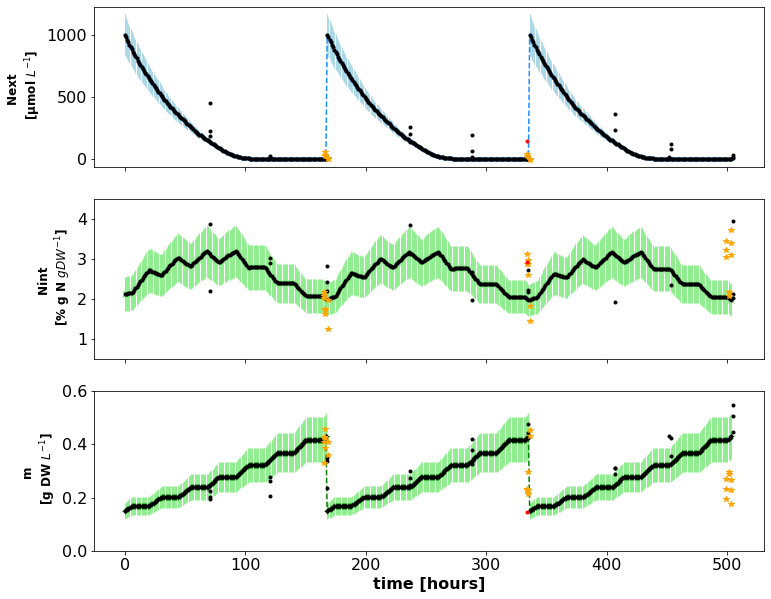

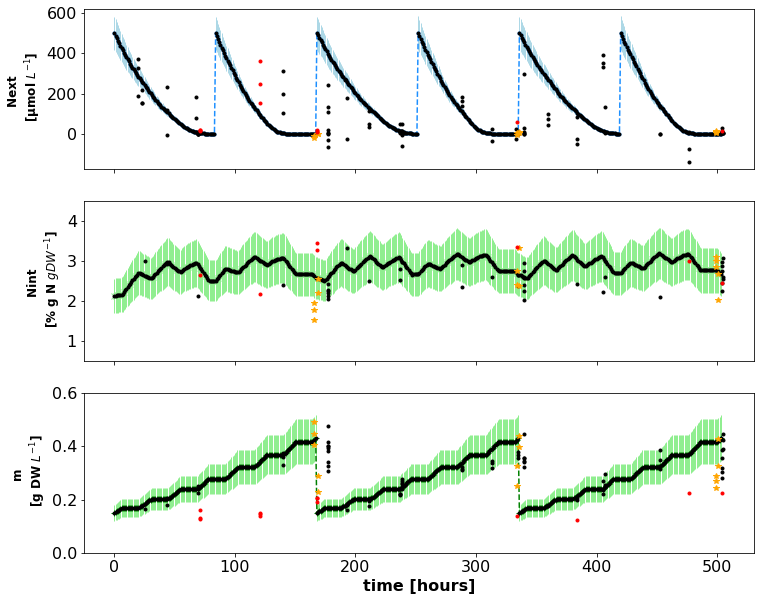

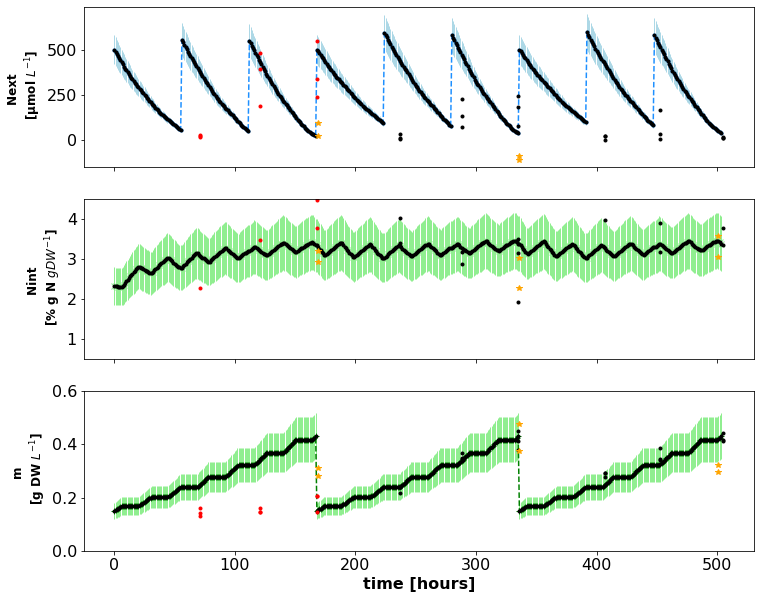

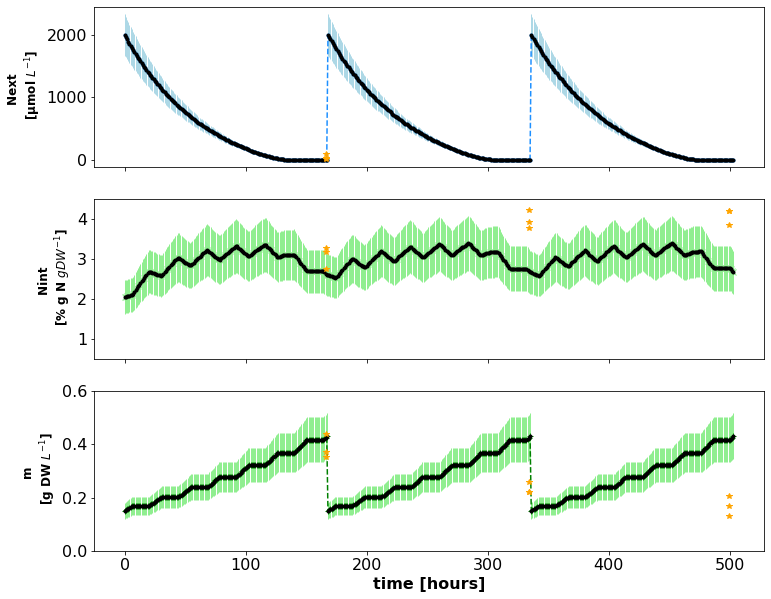

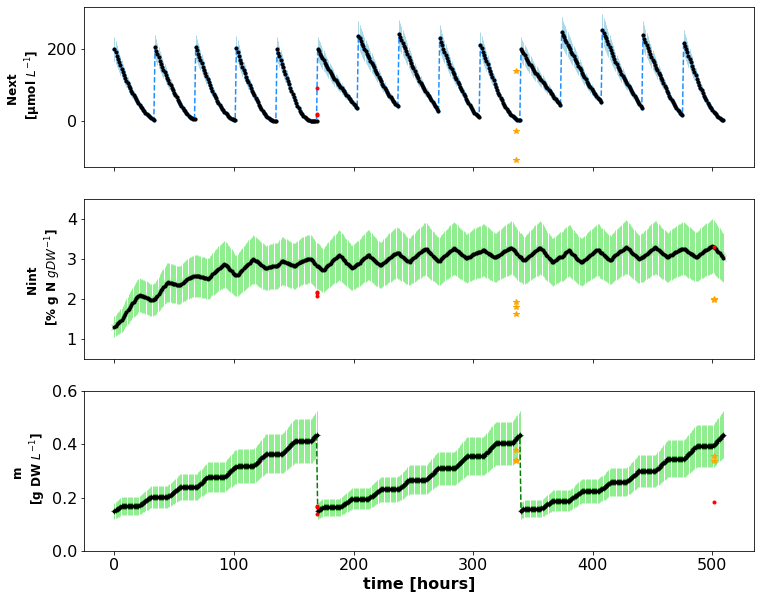

In [47]:
#n = 2
# Visual calibration of high resolution data (data from sporulation events was excluded)

# Calibration data - experiments #3 and #4 (black)
# Validation data - experiments #1, #2 and #5 (orange)
#Ka = 0.15

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

Temp = 22
#I0 = 80
S = 39 # fix salinity function and S=40

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')&(df2.Comment != 'Exclude')]
df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    mTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['DW']
    mTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['T']
    NintTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['N']
    NintTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['T']
    NextTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['NH4']
    NextTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude / Period / Duration parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    # hour = 0 is 1pm (Meiron)
    # in the indoor settings we have to solve for shorter periods, 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the last Amplitude, 
    # m0 to the end of previous solution of ode()
    # 
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the iniital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 then replace the lines above with
    # the following line and then it will also give you a constant solution you had before
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
        t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

        x = odeint(controlled_N_constST,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Z,KI,K0,Ka,
                losses20,teta,umol_to_percent_DW,I0,Temp),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)
    #Calibration experimental data
    mExpAllTimes_cal.append(mTimeTemp_cal)
    NintExpAllTimes_cal.append(NintTimeTemp_cal)
    NextExpAllTimes_cal.append(NextTimeTemp_cal)
    
    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    #Sporulation experimental data
    if len(mTimeTemp_spor) > 0: #np.empty(mTimeTemp_spor) != True:
        mExpAllTimes_spor.append(mTimeTemp_spor)
        NintExpAllTimes_spor.append(NintTimeTemp_spor)
        NextExpAllTimes_spor.append(NextTimeTemp_spor)
    

    # error bars according to calibration error
    yerrm1,yerrNext1,yerrNint1 = [],[],[]
    for i in m_model:
        yerrm1.append(0.202*i)
    for i in Nint_model:
        yerrNint1.append(0.202*i)
    for i in Next_model:
        yerrNext1.append(0.165*i)
    
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,yerrNint=yerrNint1,tNint=NintTimeTemp_cal,m=mTemp_cal,yerrm=yerrm1,tm=mTimeTemp_cal,Next=NextTemp_cal,yerrNext=yerrNext1,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)

In [34]:
# Calibration data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [35]:
# Calibration data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        mSRE_All.append((((mexp.iloc[k]-mmod[k])/mmod[k])**2)) # All Square Relative Errors
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        NintSRE_All.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # All Square Relative Errors
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 27

Sample #91
Measured biomass: 0.201
Modeled biomass: 0.225

Relative Error: 0.106

Sample #91
Measured biomass: 0.261
Modeled biomass: 0.302

Relative Error: 0.137

Sample #92
Measured biomass: 0.225
Modeled biomass: 0.225

Relative Error: 0.001

Sample #92
Measured biomass: 0.276
Modeled biomass: 0.302

Relative Error: 0.087

Sample #93
Measured biomass: 0.195
Modeled biomass: 0.225

Relative Error: 0.133

Sample #93
Measured biomass: 0.204
Modeled biomass: 0.302

Relative Error: 0.325

Sample #91
Measured biomass: 0.336
Modeled biomass: 0.383

Relative Error: 0.123

Sample #92
Measured biomass: 0.348
Modeled biomass: 0.383

Relative Error: 0.092

Sample #93
Measured biomass: 0.234
Modeled biomass: 0.383

Relative Error: 0.389

Sample #101
Measured biomass: 0.246
Modeled biomass: 0.22

Relative Error: 0.118

Sample #101
Measured biomass: 0.327
Modeled biomass: 0.298

Relative Error: 0.096

Sample #102
Measured biomass: 0.3
Modeled biomas

Modeled Nint: 3.07

Sample #76
Measured Nint: 2.031
Modeled Nint: 3.07

Sample #81
Measured Nint: 2.225
Modeled Nint: 3.448

Sample #84
Measured Nint: 2.415
Modeled Nint: 3.344

Sample #81
Measured Nint: 2.963
Modeled Nint: 3.093

Sample #83
Measured Nint: 2.879
Modeled Nint: 3.093

Sample #84
Measured Nint: 2.456
Modeled Nint: 3.093

Sample #85
Measured Nint: 2.755
Modeled Nint: 3.093

Sample #86
Measured Nint: 2.237
Modeled Nint: 3.093

Sample #104
Measured Nint: 2.794
Modeled Nint: 3.411

Sample #104
Measured Nint: 2.889
Modeled Nint: 3.394

Sample #105
Measured Nint: 2.532
Modeled Nint: 3.411

Sample #105
Measured Nint: 2.348
Modeled Nint: 3.394

Sample #104
Measured Nint: 2.639
Modeled Nint: 3.108

Sample #105
Measured Nint: 2.366
Modeled Nint: 3.108

Sample #114
Measured Nint: 2.096
Modeled Nint: 3.485

Sample #115
Measured Nint: 2.6
Modeled Nint: 3.399

Sample #114
Measured Nint: 2.544
Modeled Nint: 3.093

Sample #115
Measured Nint: 3.065
Modeled Nint: 3.093

Sample #116
Measure

C:\Users\meiro\Anaconda3new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Next

Number of samples: 18

Sample #107
Measured Next: 30.296
Modeled Next: 497.382

Sample #107
Measured Next: 70.221
Modeled Next: 557.532

Sample #108
Measured Next: 4.428
Modeled Next: 497.382

Sample #108
Measured Next: 133.714
Modeled Next: 557.532

Sample #109
Measured Next: 9.218
Modeled Next: 497.382

Sample #109
Measured Next: 226.212
Modeled Next: 557.532

Sample #107
Measured Next: 179.653
Modeled Next: 111.616

Sample #108
Measured Next: 244.267
Modeled Next: 111.616

Sample #109
Measured Next: 75.224
Modeled Next: 111.616

Sample #117
Measured Next: 18.911
Modeled Next: 479.605

Sample #117
Measured Next: 29.642
Modeled Next: 594.668

Sample #118
Measured Next: 21.413
Modeled Next: 479.605

Sample #118
Measured Next: 3.058
Modeled Next: 594.668

Sample #119
Measured Next: 0.0
Modeled Next: 479.605

Sample #119
Measured Next: 165.092
Modeled Next: 594.668

Sample #117
Measured Next: 11.708
Modeled Next: 105.863

Sample #118
Measured Next: 8.868
Modeled Next: 105.863

Sam

C:\Users\meiro\Anaconda3new\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\meiro\Anaconda3new\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
# Biomass model error of calibration data

RMSREm = round((np.mean(mSRE_All))**0.5,3)
print(RMSREm)
#0.154

0.183


In [37]:
# Nint model error of calibration data


RMSRENint = round((np.mean(NintSRE_All))**0.5,3)
print(RMSRENint)
#0.232

0.221


In [38]:
# print errors:
RMSREm = round((np.mean(mSRE_All))**0.5,3)
RMSRENint = round((np.mean(NintSRE_All))**0.5,3)

print('\nError of m is: ' + str(RMSREm))
print('\nError of Nint is: ' + str(RMSRENint))


Error of m is: 0.183

Error of Nint is: 0.221


In [39]:
miu = 0.03
#miu = X[0]
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 1.6 #1.7 #1.8 #2.3 #2
dNextoutdt = 0.015 #0.01
Ks = 23 #15.5
Vmax = 60 # 50
KI = 16
K0 = 0.5 #2# 2.4
Ka = 0.1 #0.085 #0.07 #0.12
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1


Treatment: 1000/1/168
Number of samples:
m: 27 Nint: 19 Next: 26
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 500/2/168
Number of samples:
m: 66 Nint: 38 Next: 90
3.5
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


84.0
Period
168.0
Duration
252.0
Period
336.0
Duration
420.0
Period

Treatment: 500/3/168
Number of samples:
m: 18 Nint: 12 Next: 18
2.3333333333333335
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


56.0
Period
112.0
Period
168.0
Duration
224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period

Treatment: 2000/1/168
Number of samples:
m: 0 Nint: 0 Next: 0
7.0
0.0
Starting point


C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


168.0
Duration
336.0
Duration

Treatment: 200/5/168
Number of samples:
m: 0 Nint: 0 Next: 0
1.4
0.0
Starting point
34.0

C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Period
68.0
Period
102.0
Period
136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period


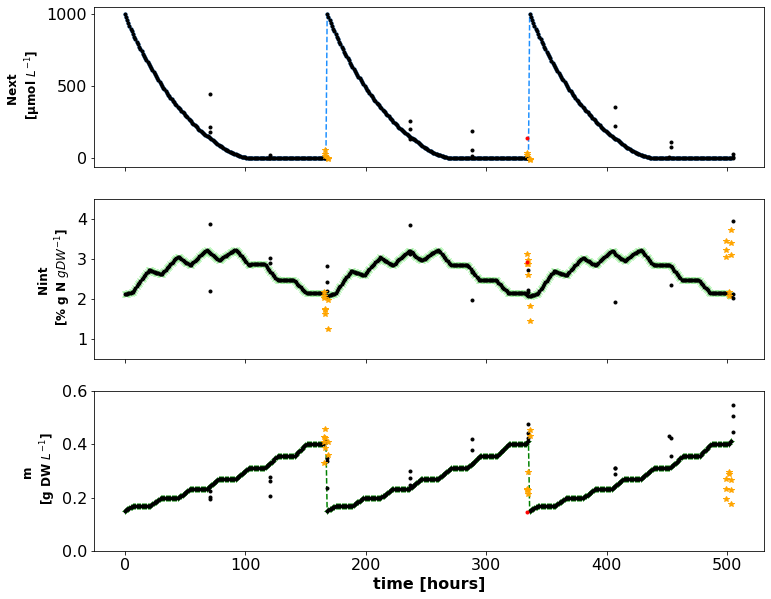

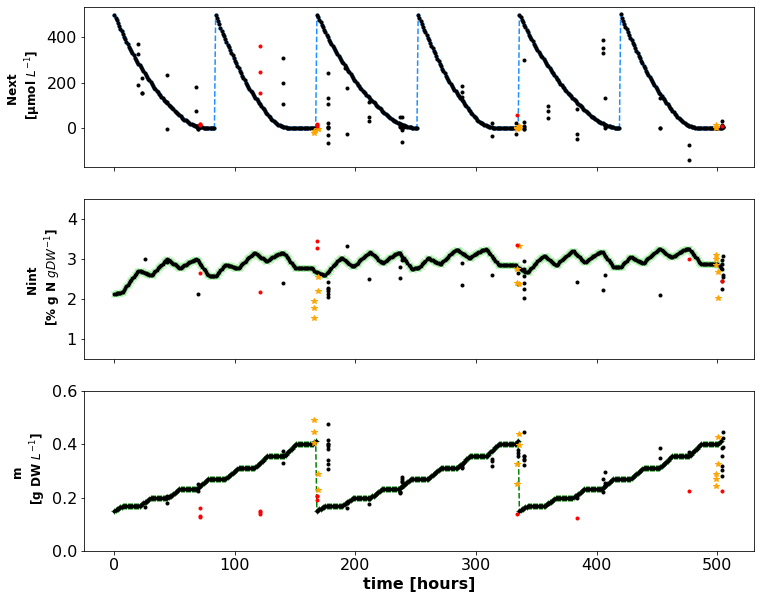

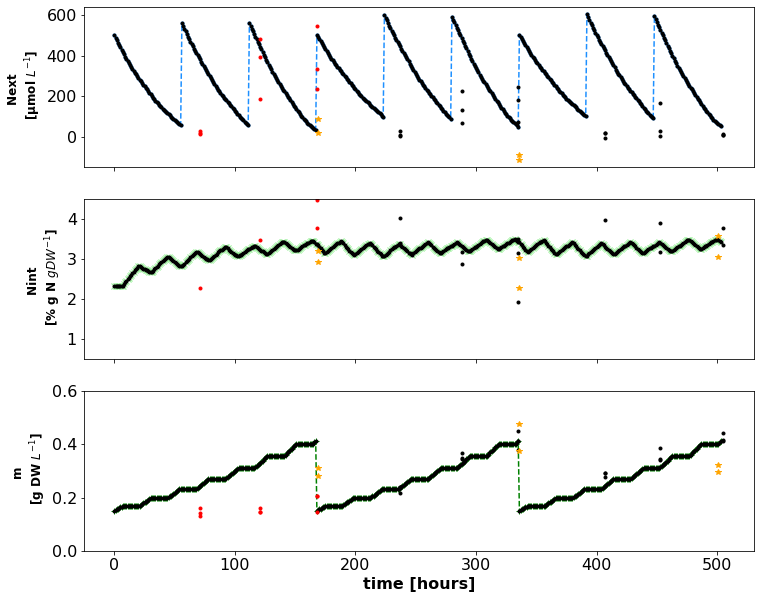

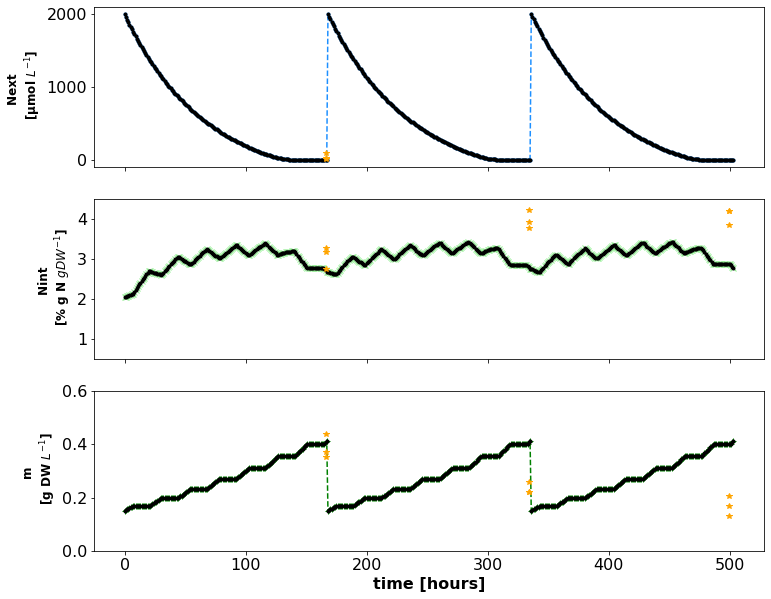

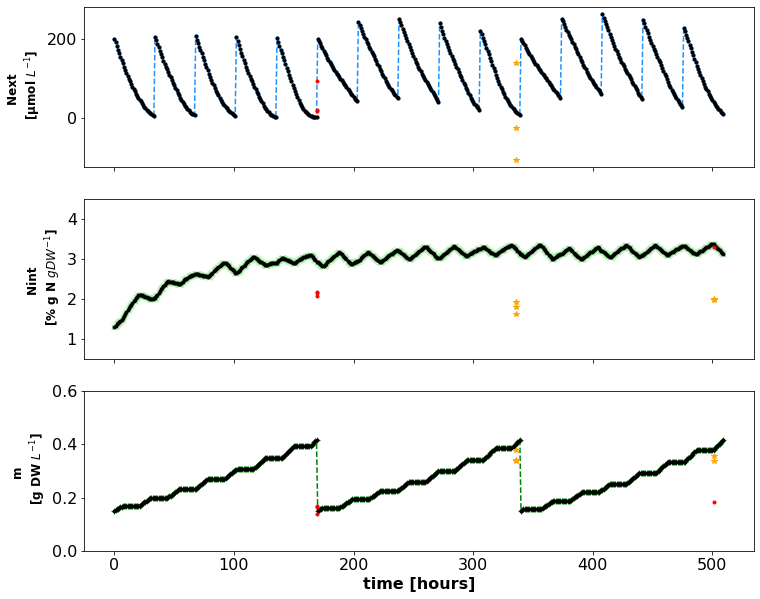

In [40]:
#n = 2
# Visual calibration of high resolution data (data from sporulation events was excluded)

# Calibration data - experiments #3 and #4 (black)
# Validation data - experiments #1, #2 and #5 (orange)
#Ka = 0.15

TModAll = [] # Each sub-array has the time steps of a specific treatment (periods)
mExpAllTimes_cal,NintExpAllTimes_cal,NextExpAllTimes_cal = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]
mExpAllTimes_val,NintExpAllTimes_val,NextExpAllTimes_val = [],[],[]
mModAll_val,NintModAll_val,NextModAll_val = [],[],[]
mExpAllTimes_spor,NintExpAllTimes_spor,NextExpAllTimes_spor = [],[],[]
mModAll_spor,NintModAll_spor,NextModAll_spor = [],[],[]

mTimeTemp_spor = 0

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']
Nint0All = ['2.12','2.13','2.32','2.05','1.3']

Temp = 22
#I0 = 80
S = 39 # fix salinity function and S=40

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')&(df2.Comment != 'Exclude')]
df2_cal = df2_Reduced[(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)]
df2_val = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)]
df2_spor = df2[(np.isnan(df2.DW) != True)&(df2.Treatment != 'Acclimation')&(df2.Duration == 168) & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'Yes')&(df2.Comment != 'Exclude')]


for i in Treatments:
    print('\nTreatment: ' + str(i))
    # calibration data
    df2Temp_cal = df2_cal[(df2_Reduced.Treatment == i)]
    mTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['DW']
    mTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.DW) != True)]['T']
    NintTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['N']
    NintTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.N) != True)]['T']
    NextTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['NH4']
    NextTimeTemp_cal = df2Temp_cal[(np.isnan(df2Temp_cal.NH4) != True)]['T']
    
    # validation data
    df2Temp_val = df2_val[(df2_Reduced.Treatment == i)]
    mTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['DW']
    mTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.DW) != True)]['T']
    NintTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['N']
    NintTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.N) != True)]['T']
    NextTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['NH4']
    NextTimeTemp_val = df2Temp_val[(np.isnan(df2Temp_val.NH4) != True)]['T']
    mTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['DW']
    mTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.DW))]['T']
    NintTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['N']
    NintTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.N))]['T']
    NextTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['NH4']
    NextTimeTemp_val = df2Temp_val[(~np.isnan(df2Temp_val.NH4))]['T']
    
    # sporulation data
    del mTimeTemp_spor
    df2Temp_spor = df2_spor[(df2_spor.Treatment == i)]
    mTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['DW']
    mTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.DW) != True)]['T']
    NintTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['N']
    NintTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.N) != True)]['T']
    NextTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(np.isnan(df2Temp_spor.NH4) != True)]['T']
    mTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['DW']
    mTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.DW))]['T']
    NintTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['N']
    NintTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.N))]['T']
    NextTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['NH4']
    NextTimeTemp_spor = df2Temp_spor[(~np.isnan(df2Temp_spor.NH4))]['T']
    
    print('Number of samples:\nm: ' + str(len(mTimeTemp_cal)) + ' Nint: ' + str(len(NintTimeTemp_cal)) + ' Next: ' + str(len(NextTimeTemp_cal)))
    
    # Amplitude / Period / Duration parameters from input
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1]) # Period is in hours
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    # hour = 0 is 1pm (Meiron)
    # in the indoor settings we have to solve for shorter periods, 
    # at the beginning of the Treatment we reset Nint, Next, m
    # at the beginning of each Period we set Next to the last Amplitude, 
    # m0 to the end of previous solution of ode()
    # 
    
    # Let's prepare the IO(t) function that will be supplied to odeint 
    # instead of a scalar. 
    
    all_treatment_hours = np.arange(0,n_days*24,dtype=np.int)
    
    # 8pm on the first day is zero crossing of this one 8pm - 10m = 7 hours
    offtimes = all_treatment_hours[np.mod(all_treatment_hours - 7,24) == 0]
    offtimes = np.r_[offtimes,all_treatment_hours[-1]+1] # last hour would be whatever
    
    # 6am on the next day is zero crossing of this one, 6am - 8pm is 10 hours
    ontimes = all_treatment_hours[np.mod(all_treatment_hours - 7 + 10,24) == 0]
    # and the iniital hour as we always start at 1pm, during ontime
    ontimes = np.r_[np.int(0),ontimes]
    
    # prepare the duty cycle
    I0set = np.zeros_like(all_treatment_hours)
    for s,e in zip(ontimes,offtimes):
        I0set[s:e] = 80
        
    # if you want to replace it by a "constant" I0 then replace the lines above with
    # the following line and then it will also give you a constant solution you had before
    
    # I0set = np.ones_like(all_treatment_hours)*80

    
    I0 = interpolate.interp1d(all_treatment_hours, I0set, bounds_error=False, fill_value="extrapolate")
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0All[Treatments.index(i)]
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]
   
                
        # Here we want to send odeint the times of the light sub-period or 
        # darkness sub-period

        x0 = [Next_0,Nint_0,m_0]
        # t = np.linspace(hour,hour+Period*24) # every time we solve ODE for 24 hours * Period
        t = np.arange(hour, hour+Period*24) # can also ask for report on round hours

        x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0),printmessg=0,hmax=.1)

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    TModAll.append(TT)
    #Calibration experimental data
    mExpAllTimes_cal.append(mTimeTemp_cal)
    NintExpAllTimes_cal.append(NintTimeTemp_cal)
    NextExpAllTimes_cal.append(NextTimeTemp_cal)
    
    #model data
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)
    
    #Valiaation experimental data
    mExpAllTimes_val.append(mTimeTemp_val)
    NintExpAllTimes_val.append(NintTimeTemp_val)
    NextExpAllTimes_val.append(NextTimeTemp_val)
    
    #Sporulation experimental data
    if len(mTimeTemp_spor) > 0: #np.empty(mTimeTemp_spor) != True:
        mExpAllTimes_spor.append(mTimeTemp_spor)
        NintExpAllTimes_spor.append(NintTimeTemp_spor)
        NextExpAllTimes_spor.append(NextTimeTemp_spor)
    
    #Validation model data
    #mModAll_val.append(m_model_val)
    #NintModAll_val.append(Nint_model_val)
    #NextModAll_val.append(Next_model_val) 
    
    #plot_result(t_model,Next_model,Nint_model,m_model,Nint=NintTemp,tNint=NintTimeTemp,m=mTemp,tm=mTimeTemp,Next=NextTemp,tNext=NextTimeTemp)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_val,tNint=NintTimeTemp_val,m=mTemp_val,tm=mTimeTemp_val,Next=NextTemp_val,tNext=NextTimeTemp_val)
    #plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val )
    plot_result_extra(t_model,Next_model,Nint_model,m_model,Nint=NintTemp_cal,tNint=NintTimeTemp_cal,m=mTemp_cal,tm=mTimeTemp_cal,Next=NextTemp_cal,tNext=NextTimeTemp_cal,Next_val = NextTemp_val,tNext_val =NextTimeTemp_val,Nint_val = NintTemp_val,tNint_val =NintTimeTemp_val,m_val = mTemp_val,tm_val =mTimeTemp_val,Next_spor = NextTemp_spor,tNext_spor =NextTimeTemp_spor,Nint_spor = NintTemp_spor,tNint_spor =NintTimeTemp_spor,m_spor = mTemp_spor,tm_spor =mTimeTemp_spor)

In [41]:
# Calibration data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_cal[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [42]:
# Calibration data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        mSRE_All.append((((mexp.iloc[k]-mmod[k])/mmod[k])**2)) # All Square Relative Errors
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        NintSRE_All.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # All Square Relative Errors
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 27

Sample #91
Measured biomass: 0.201
Modeled biomass: 0.239

Relative Error: 0.158

Sample #91
Measured biomass: 0.261
Modeled biomass: 0.326

Relative Error: 0.199

Sample #92
Measured biomass: 0.225
Modeled biomass: 0.239

Relative Error: 0.057

Sample #92
Measured biomass: 0.276
Modeled biomass: 0.326

Relative Error: 0.153

Sample #93
Measured biomass: 0.195
Modeled biomass: 0.239

Relative Error: 0.183

Sample #93
Measured biomass: 0.204
Modeled biomass: 0.326

Relative Error: 0.374

Sample #91
Measured biomass: 0.336
Modeled biomass: 0.411

Relative Error: 0.182

Sample #92
Measured biomass: 0.348
Modeled biomass: 0.411

Relative Error: 0.153

Sample #93
Measured biomass: 0.234
Modeled biomass: 0.411

Relative Error: 0.43

Sample #101
Measured biomass: 0.246
Modeled biomass: 0.233

Relative Error: 0.056

Sample #101
Measured biomass: 0.327
Modeled biomass: 0.322

Relative Error: 0.017

Sample #102
Measured biomass: 0.3
Modeled biomas

Measured Next: 137.516
Modeled Next: 132.583

Sample #104
Measured Next: 6.806
Modeled Next: 0.0

Sample #105
Measured Next: 7.608
Modeled Next: 0.0

Sample #106
Measured Next: 0.512
Modeled Next: 0.0

Sample #114
Measured Next: 9.537
Modeled Next: 18.583

Sample #114
Measured Next: 0.0
Modeled Next: 156.938

Sample #115
Measured Next: 2.89
Modeled Next: 18.583

Sample #115
Measured Next: 132.902
Modeled Next: 156.938

Sample #116
Measured Next: 130.843
Modeled Next: 18.583

Sample #116
Measured Next: 0.801
Modeled Next: 156.938

Sample #114
Measured Next: 4.461
Modeled Next: 0.0

Sample #115
Measured Next: 3.85
Modeled Next: 0.0

Sample #116
Measured Next: 6.151
Modeled Next: 0.0


The RMSRE of Next in treamtment 500/2/168 is: 510023.513

Treatment: 500/3/168

m

Number of samples: 18

Sample #107
Measured biomass: 0.24
Modeled biomass: 0.233

Relative Error: 0.03

Sample #107
Measured biomass: 0.345
Modeled biomass: 0.322

Relative Error: 0.073

Sample #108
Measured biomass: 0.216
Mo

C:\Users\meiro\Anaconda3new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\meiro\Anaconda3new\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\meiro\Anaconda3new\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\meiro\Anaconda3new\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
# print errors:
RMSREm = round((np.mean(mSRE_All))**0.5,3)
RMSRENint = round((np.mean(NintSRE_All))**0.5,3)

print('\nError of m is: ' + str(RMSREm))
print('\nError of Nint is: ' + str(RMSRENint))


Error of m is: 0.154

Error of Nint is: 0.208


In [44]:
# 0.181, 0.224
#0.181, 0.209
#0.181, 0.207
#0.178, 0.207
#0.161, 0.239
#0.154, 0.219
# 0.159, 0.209

In [45]:
# Validation data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

#mExpAllTimes_val_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [46]:
# Validation data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    #df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]
    df2m = df2_val
    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        mSRE_All.append((((mexp.iloc[k]-mmod[k])/mmod[k])**2)) # All Square Relative Errors
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        NintSRE_All.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # All Square Relative Errors
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    #df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 1)&(df2_Reduced.Exp != 2)&(df2_Reduced.Exp != 5)&(df2_Reduced.Treatment == Treatments[i])]
    #print('\nNext\n')
    #print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    #k = 0
    #for j in df2Next.Sample:
    #    Nextexp = df2Next.NH4
    #    if Nextexp.iloc[k] < 0:
    #        Nextexp.iloc[k] = 0
    #    Nextmod = NextModReducedAll[i]
    #    NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
    #    print('Sample #' + str(math.floor(float(j))))
    #    print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
    #    print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
    #    k = k + 1
    #RMSRENext = round((np.mean(NextSRE))**0.5,3)
    #NextSRE_All.append(NextSRE)
    #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 63

Sample #1
Measured biomass: 0.408
Modeled biomass: 0.399

Relative Error: 0.021

Sample #2
Measured biomass: 0.426
Modeled biomass: 0.399

Relative Error: 0.067

Sample #3
Measured biomass: 0.33
Modeled biomass: 0.399

Relative Error: 0.174

Sample #4
Measured biomass: 0.267
Modeled biomass: 0.407

Relative Error: 0.343

Sample #5
Measured biomass: 0.267
Modeled biomass: 0.407

Relative Error: 0.343

Sample #6
Measured biomass: 0.216
Modeled biomass: 0.407

Relative Error: 0.469

Sample #7
Measured biomass: 0.228
Modeled biomass: 0.407

Relative Error: 0.439

Sample #8
Measured biomass: 0.234
Modeled biomass: 0.407

Relative Error: 0.424

Sample #9
Measured biomass: 0.309
Modeled biomass: 0.407

Relative Error: 0.24

Sample #11
Measured biomass: 0.294
Modeled biomass: 0.402

Relative Error: 0.269

Sample #12
Measured biomass: 0.213
Modeled biomass: 0.402

Relative Error: 0.47

Sample #13
Measured biomass: 0.228
Modeled biomass: 0.402

Re

IndexError: list index out of range

In [ ]:
# Validation data error - step 1: calculte model prediction for each measurement

# This cell adjusts measurment time to model durations - so that maximum biomass measurements
# are compared to maximum biomass predictions and not to the initial stocking density (m0)


# constrain times to end at 504 hours
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)): # loops over 5 treatments
    print(i)
    for j in range(len(TModAll[i])): # Loops over periods in each treatment
        Ttemp = TModAll[i][j]
        for k in Ttemp: #The model ends at 504 hours, but some measurement reach also 50 hours. This sets a 504 hour limit
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

#mExpAllTimes_cal_new = []
for i in range(len(TModAll)):
    
    # Calculate m model predictions - if time is out of bounderies, maximal model value is chosen
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        elif j >= 336 and j < 345:
            j = 335.9
        elif j > 504:
            j = 504
        mModReduced.append(gm(j-1))
    mModReducedAll.append(mModReduced)  
    
    # Calculate Nint model predictions - if time is out of bounderies, maximal model value is chosen
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j-1))
    NintModReducedAll.append(NintModReduced)
    
    # Calculate Next model predictions - if time is out of bounderies, maximal model value is chosen
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes_val[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j-1))
    NextModReducedAll.append(NextModReduced)

In [ ]:
# Validation data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    mSRE_All.append(mSRE) # All Square Relative Errors
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    NintSRE_All.append(NintSRE) # All Square Relative Errors
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    #df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]
    #print('\nNext\n')
    #print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    #k = 0
    #for j in df2Next.Sample:
    #    Nextexp = df2Next.NH4
    #    if Nextexp.iloc[k] < 0:
    #        Nextexp.iloc[k] = 0
    #    Nextmod = NextModReducedAll[i]
    #    NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
    #    print('Sample #' + str(math.floor(float(j))))
    #    print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
    #    print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
    #    k = k + 1
    #RMSRENext = round((np.mean(NextSRE))**0.5,3)
    #NextSRE_All.append(NextSRE)
    #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

In [ ]:
# Validation data error - step 2: calculte errors for each variable

mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    # Biomass
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]

    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample: # loop over all samples
        mexp = df2m.DW # measured m
        mmod = mModReducedAll[i] # predicted m
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        print('Relative Error: ' + str(round(float(mSRE[k]**0.5),3)) + '\n')
        mSRE_All.append((((mexp.iloc[k]-mmod[k])/mmod[k])**2)) # All Square Relative Errors
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3) # Root Mean Square relative error
    
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    # Internal N
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]

    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample: # loop over all samples
        Nintexp = df2Nint.N # measured Nint
        Nintmod = NintModReducedAll[i] # predicted Nint
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # Square relative error
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        NintSRE_All.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2) # All Square Relative Errors
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3) #RMSRE
    
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    # External N
    #df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)&(df2_Reduced.Exp != 3)&(df2_Reduced.Exp != 4)&(df2_Reduced.Treatment == Treatments[i])]
    #print('\nNext\n')
    #print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    #k = 0
    #for j in df2Next.Sample:
    #    Nextexp = df2Next.NH4
    #    if Nextexp.iloc[k] < 0:
    #        Nextexp.iloc[k] = 0
    #    Nextmod = NextModReducedAll[i]
    #    NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
    #    print('Sample #' + str(math.floor(float(j))))
    #    print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
    #    print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
    #    k = k + 1
    #RMSRENext = round((np.mean(NextSRE))**0.5,3)
    #NextSRE_All.append(NextSRE)
    #print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
print('End of treatment ' + str(Treatments[i]) + '\n')

In [ ]:
# print errors:
RMSREm = round((np.mean(mSRE_All))**0.5,3)
RMSRENint = round((np.mean(NintSRE_All))**0.5,3)

print('\nError of m is: ' + str(RMSREm))
print('\nError of Nint is: ' + str(RMSRENint))